## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [7]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [8]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [10]:
import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [11]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [13]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSBSBS'
meas='SNWD'
meas_tmp='PRCP'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
#filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas_tmp)


df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
2639
+-------------------+-------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
| -325.7820162333926| 315.89363520499944|-59.28977326081643|      3.7|BSBSBSBS| 25.8175| -80.2858|       PRCP|0.9501597572800703|0.9082645853470678|0.9062953356908859|0.7597993003882532|USC0008

In [15]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00083909| 25.8175| -80.2858|      3.7| -325.7820162333926|
|USW00012844| 26.6847| -80.0994|      5.8|-214.60618106827985|
|USC00086315|   25.95| -80.2158|      3.0| 111.75025178850504|
|USC00085653| 25.7833| -80.1833|      3.0| -264.0503495452349|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [22]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['longitude'],inplace=True)
pdf


,station,latitude,longitude,elevation,count(station),avg(coeff_1)
146,USC00083571,27.8000,-81.2000,14.3,7,6.399088
93,USC00086404,27.8000,-81.2000,18.3,1,90.374070
114,USC00081869,27.4000,-81.1667,11.9,24,67.562287
35,USC00082298,26.6033,-81.1292,6.1,49,-23.552524
13,USC00085866,25.8500,-81.1000,-999.9,2,109.089582
140,USC00085895,26.8400,-81.0872,10.7,91,16.896376
142,USC00080992,27.0436,-81.0700,4.3,7,38.789255
131,USW00012896,24.7258,-81.0517,2.4,13,129.421113
134,USC00085351,24.7333,-81.0500,3.0,17,97.669127
148,USC00081651,26.7361,-81.0492,5.5,10,62.661391


In [17]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [23]:
min_lat,max_lat,min_long,max_long = box = (24.0667, 27.8703,-81.2000, -74.5167)


In [24]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

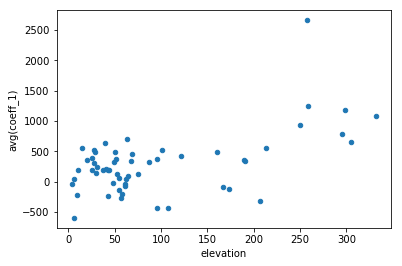

In [16]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [21]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']